# Thermostat

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} -k \cdot \textit{temp} + h \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              -k \cdot \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

In [1]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

### Original model

In [2]:
def orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.1):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = init_T
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
        
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h + noise.rsample() 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] + noise.rsample() 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj        


# same model without noise
def det_orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = init_T
        
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj    


# model smoothed with sigmoid (for pyro)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def smooth_orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.1, sharpness=1.):
    
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    traj = torch.zeros(T)
    isOn = 0.
    traj[0] = init_T
        
    for i in range(1,T):
        
        turn_on = sigmoid(sharpness * (tOn - traj[i-1]))
        turn_off = sigmoid(sharpness * (traj[i-1] - tOff))
        isOn = isOn * (1 - turn_off) + (1 - isOn) * turn_on

        traj[i] = traj[i-1] -k*traj[i-1] + h * isOn + noise.sample()
            
    return traj    

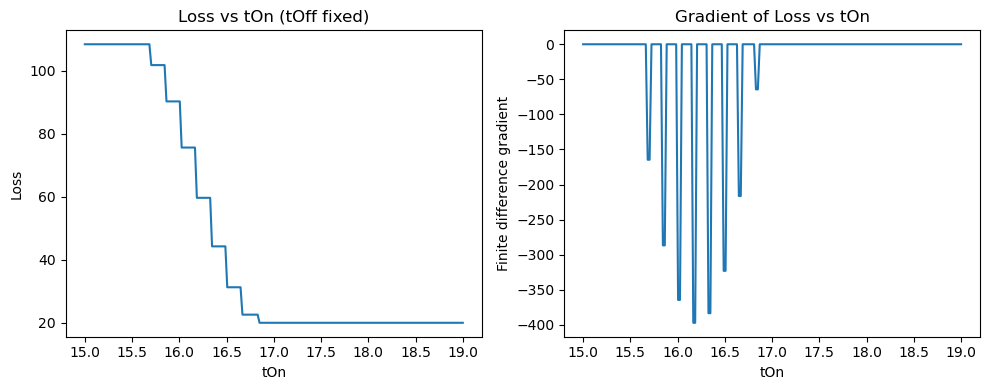

In [ ]:
# without noise the model is discontinuous 

import numpy as np
import matplotlib.pyplot as plt


# does it make sense to use this? 
def loss_for_params(model, tOn, tOff, batch_size):
    # Use the original model to generate trajectories with fixed tOn, tOff
    # and compute negative log likelihood on the observed data
    trajs = []
    for _ in range(batch_size):  # use a small batch for speed
        trajs.append(model(tOn=tOn, tOff=tOff))
    trajs = torch.vstack(trajs)
    # Negative log likelihood under the observed data
    # (use the same likelihood as in your SVI)
    with torch.no_grad():
        loss = 0
        for i in range(traj_set.shape[0]):
            loss += -torch.distributions.Normal(trajs.mean(0), 0.5).log_prob(traj_set[i]).sum()
        loss /= traj_set.shape[0]   # added normalization
    return loss.item()

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 200)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(det_orig_model, tOn, tOff_fixed, batch_size=1))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()

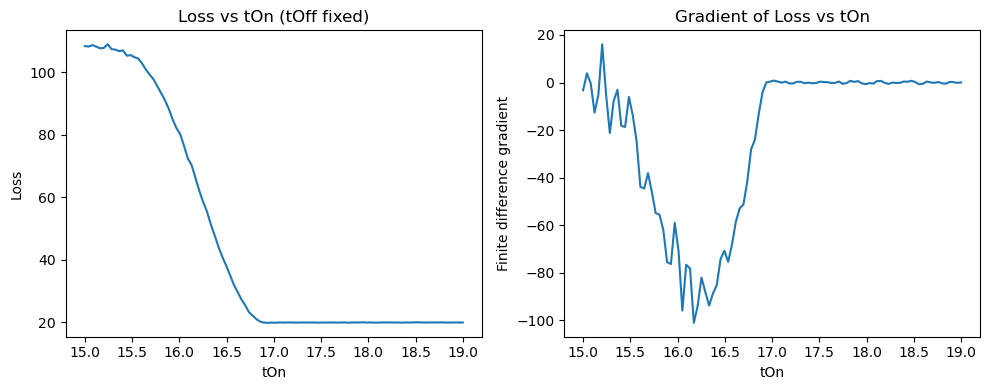

In [96]:
# with noise the loss is continuous but the gradient oscillates a lot

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 100)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(orig_model, tOn, tOff_fixed, batch_size=1000))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)  # finite difference gradient

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()

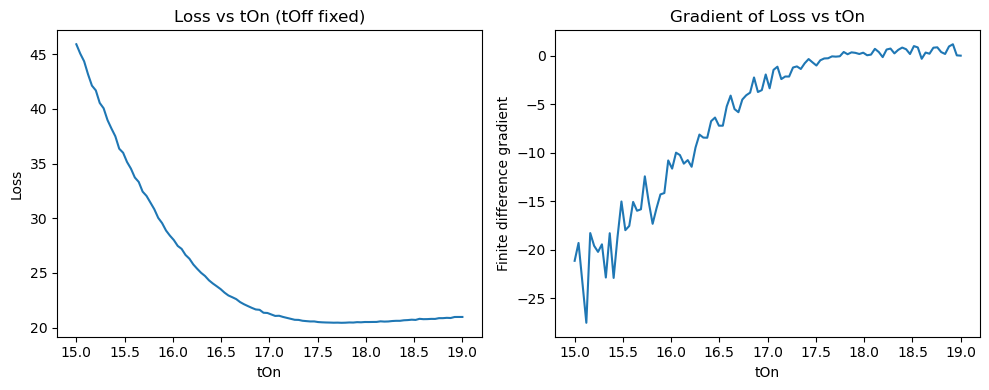

In [99]:
# with smoothing

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 100)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(smooth_orig_model, tOn, tOff_fixed, batch_size=1000))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)  # finite difference gradient

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()

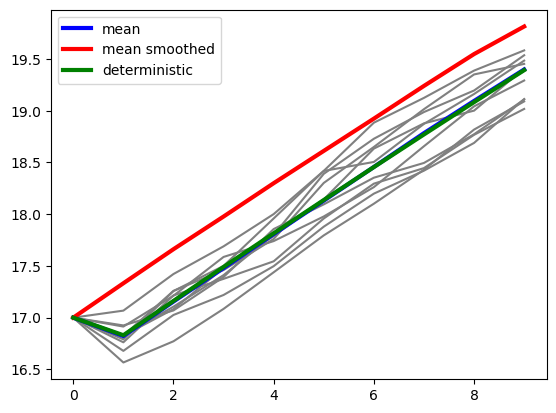

In [3]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

traj_set = []
smooth_traj_set = []
for _ in range(500):
    traj_set.append(orig_model())
    smooth_traj_set.append(smooth_orig_model(sharpness=20., eps=0.1))
traj_set = torch.vstack(traj_set)
smooth_traj_set = torch.vstack(smooth_traj_set)
det_traj = det_orig_model()

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='blue', label='mean')
plt.plot(range(10), torch.mean(smooth_traj_set, 0), lw=3, color='red', label='mean smoothed')
plt.plot(range(10), det_traj, lw=3, color='green', label='deterministic')
plt.legend()

### MCMC Optimization

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, HMC
import torch



def pyro_model_mcmc(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.5):
    tOn = pyro.sample("tOn", dist.Normal(16.0, 1.0))
    tOff = pyro.sample("tOff", dist.Normal(22.0, 1.0))

    batch_size = observed_traj.shape[0]
    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_T
    isOn = torch.zeros(batch_size, dtype=torch.bool)
    noise = dist.Normal(0.0, eps)

    for i in range(1, T):
        traj[:, i] = traj[:, i - 1] - k * traj[:, i - 1] + noise.sample([batch_size])
        traj[:, i] += h * isOn.float()
        isOn = torch.where((isOn & (traj[:, i] > tOff)) | (~isOn & (traj[:, i] < tOn)), ~isOn, isOn)

    with pyro.plate("data", batch_size):
        pyro.sample("obs", dist.Normal(traj, eps).to_event(1), obs=observed_traj)



def pyro_model_mcmc_smooth(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.5, sharpness=0.1):
    
    # higher sharpness means sharper transitions 
    tOn = pyro.sample("tOn", dist.Normal(16.0, 2.0))
    tOff = pyro.sample("tOff", dist.Normal(22.0, 2.0))

    batch_size = observed_traj.shape[0]
    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_T
    isOn_prob = torch.zeros(batch_size)  # probability that isOn is True
    noise = dist.Normal(0.0, eps)

    def sigmoid(x):
        return 1 / (1 + torch.exp(-x))

    for i in range(1, T):
        # Smooth transitions
        turn_on = sigmoid(sharpness * (tOn - traj[:, i-1]))
        turn_off = sigmoid(sharpness * (traj[:, i-1] - tOff))
        isOn_prob = isOn_prob * (1 - turn_off) + (1 - isOn_prob) * turn_on

        traj[:, i] = traj[:, i-1] - k * traj[:, i-1] + h * isOn_prob + noise.sample([batch_size])

    with pyro.plate("data", batch_size):
        pyro.sample("obs", dist.Normal(traj, eps).to_event(1), obs=observed_traj)

In [ ]:
# Run NUTS 
nuts_kernel = NUTS(pyro_model_mcmc_smooth)    # NUTS fails to converge
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(traj_set)

# Extract posterior samples
posterior_samples = mcmc.get_samples()
print("Posterior mean tOn:", posterior_samples["tOn"].mean().item())
print("Posterior mean tOff:", posterior_samples["tOff"].mean().item())

Sample: 100%|██████████| 1500/1500 [00:29, 50.09it/s, step size=6.53e-42, acc. prob=0.000]


Posterior mean tOn: 288.4508710119507
Posterior mean tOff: 108.03937070002463


In [55]:
# Run HMC
hmc_kernel = HMC(pyro_model_mcmc_smooth)
mcmc = MCMC(hmc_kernel, num_samples=1000, warmup_steps=500, num_chains=1)       # painfully slow
mcmc.run(traj_set)

# Extract posterior samples
posterior_samples = mcmc.get_samples()
print("Posterior mean tOn:", posterior_samples["tOn"].mean().item())
print("Posterior mean tOff:", posterior_samples["tOff"].mean().item())

Warmup:   0%|          | 3/1500 [00:02,  1.08s/it, step size=4.17e-03, acc. prob=0.000]

KeyboardInterrupt: 

### VI Optimization

In [4]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import torch
import torch.nn.functional as F

#pyro.set_rng_seed(9)  # for some seed finds good parameters, for others it doesn't (3 is bad)

# Pyro model
def pyro_model(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.1):
    
    tOn = pyro.sample("tOn", distributions.Normal(16.0, 1.0))  
    tOff = pyro.sample("tOff", distributions.Normal(22.0, 1.0))  
    traj = torch.zeros(T)
    traj[0] = init_T
    isOn = False
    noise = dist.Normal(0.0, eps)

    for i in range(1, T):
        # Update temperature
        if isOn:
            traj[i] = traj[i - 1] - k * traj[i - 1] + h + noise.sample()
        else:
            traj[i] = traj[i - 1] - k * traj[i - 1] + noise.sample()

        # Update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True

    # Condition on observed trajectories
    N = observed_traj.shape[0]
    with pyro.plate("data", N):
        pyro.sample("obs", dist.Normal(traj, eps).to_event(1), obs=observed_traj)

# Pyro model with smooth transitions

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def pyro_model_smooth(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.1, sharpness=1.):
    
    tOn = pyro.sample("tOn", distributions.Normal(16.0, 1.0))
    tOff = pyro.sample("tOff", distributions.Normal(22.0, 1.0))

    traj = torch.zeros(T)
    traj[0] = init_T
    isOn_prob = torch.tensor(0.0)  # probability that isOn is True
    noise = dist.Normal(0.0, eps)

    for i in range(1, T):
        # Update isOn probability smoothly
        turn_on = sigmoid(sharpness * (tOn - traj[i-1]))
        turn_off = sigmoid(sharpness * (traj[i-1] - tOff))
        isOn_prob = isOn_prob * (1 - turn_off) + (1 - isOn_prob) * turn_on

        # Update temperature (weighted by isOn_prob)
        traj[i] = traj[i-1] - k * traj[i-1] + h * isOn_prob + noise.sample()

    N = observed_traj.shape[0]
    with pyro.plate("data", N):
        pyro.sample("obs", dist.Normal(traj, eps).to_event(1), obs=observed_traj)
    

# Guide (variational distribution)
def pyro_guide(observed_traj, T=10, init_T=17., k=0.01, h=0.5, eps=0.5):
    
    # Variational parameters for tOn and tOff
    tOn_loc = pyro.param("tOn_loc", torch.tensor(16.0))
    tOff_loc = pyro.param("tOff_loc", torch.tensor(22.0))

    # Sample tOn and tOff from variational distributions
    pyro.sample("tOn", dist.Normal(tOn_loc, torch.tensor(2.0)))
    pyro.sample("tOff", dist.Normal(tOff_loc, torch.tensor(2.0)))

Step 0: Loss = 615451.2705593961
Step 100: Loss = 717415.7171443604
Step 200: Loss = 586623.0834233148
Step 300: Loss = 673687.1914183398
Step 400: Loss = 660417.2633556615
Step 500: Loss = 586229.0810892803
Step 600: Loss = 760841.2817755503
Step 700: Loss = 605756.9646577328
Step 800: Loss = 666313.8091795812
Step 900: Loss = 590890.6132378016
Optimization performed in 529.75 seconds
Optimized tOn: 15.960740179241412, tOff: 21.990550064447774


Text(0, 0.5, 'Loss')

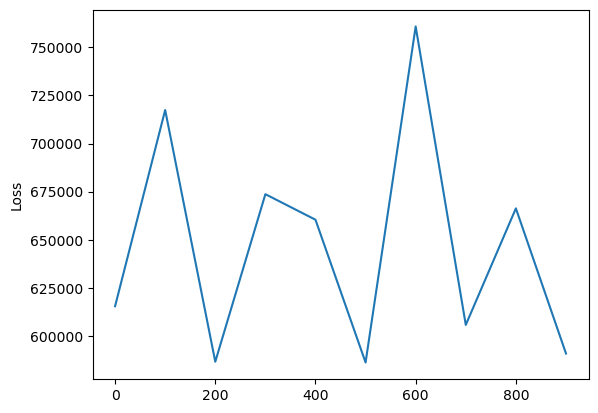

In [5]:
# SVI setup
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = SVI(pyro_model, pyro_guide, optimizer, loss=Trace_ELBO(num_particles=100))  
# I put num particles higher to see if the training stabilizes

loss_list = []
step_list = []

# Training loop
num_steps = 1000

start = time()

for step in range(num_steps):
    
    loss = svi.step(traj_set)

    if step % 100 == 0:
        loss_list.append(loss)
        step_list.append(step)
        print(f"Step {step}: Loss = {loss}")
        #for name, value in pyro.get_param_store().items():
        #    print(name, value.grad)


end = time()

print(f"Optimization performed in {end - start:.2f} seconds")

# Retrieve optimized parameters
vi_tOn = pyro.param("tOn_loc").item()
vi_tOff = pyro.param("tOff_loc").item()
print(f"Optimized tOn: {vi_tOn}, tOff: {vi_tOff}")

plt.plot(step_list, loss_list)
plt.ylabel("Loss")

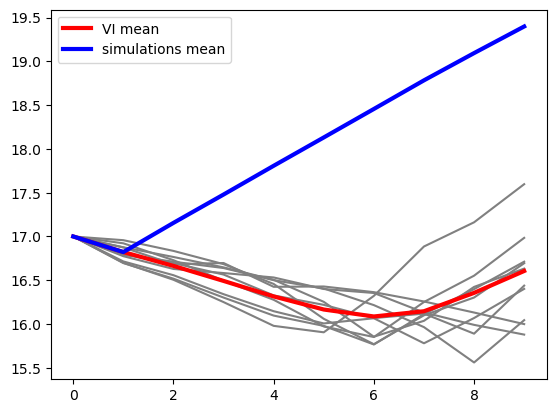

In [6]:
# Trajectories generated using the optimized parameters

import matplotlib.pyplot as plt


vi_traj_set = []
for _ in range(100):
    vi_traj_set.append(orig_model(tOn = vi_tOn, tOff = vi_tOff))
vi_traj_set = torch.vstack(vi_traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), vi_traj_set[i], color='grey')

plt.plot(range(10), torch.mean(vi_traj_set, 0), lw=3, color='red', label='VI mean')
plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='blue', label='simulations mean')

plt.legend()

### SOGA Non Bayesian

In [7]:
def optimize(cfg, traj_set, params_dict, loss_func, n_steps=100):

    optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

    total_start = time()

    for i in range(n_steps):

        optimizer.zero_grad()  # Reset gradients
    
        # loss
        current_dist = start_SOGA(cfg, params_dict)

        loss = loss_func(traj_set, current_dist)

        # Backpropagate
        loss.backward()
    
        optimizer.step()

    
        # Print progress
        if i % int(n_steps/10) == 0:
            out = ''
            for key in params_dict.keys():
                out = out + key + ': ' + str(params_dict[key].item()) + ' '
            out = out + f" loss: {loss.item()}"
            print(out)

    total_end = time()

    print('Optimization performed in ', round(total_end-total_start, 3))


In [8]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

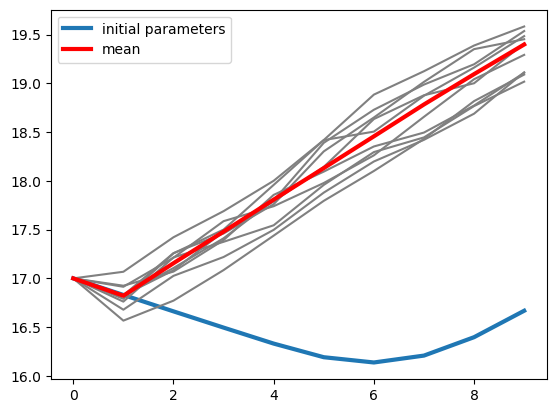

In [9]:
import matplotlib.pyplot as plt

y_init = output_dist.gm.mean()[:10].detach()
plt.plot(range(10), y_init, lw=3, label='initial parameters')

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [10]:
def neg_log_likelihood(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx], idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist)
        

tensor(149807.8684, grad_fn=<NegBackward0>)

In [11]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)
pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimize(cfg, traj_set, params_dict, neg_log_likelihood, n_steps=80)


tOff: 22.0 tOn: 16.049999999999997  loss: 149807.8684214708
tOff: 22.000042664179002 tOn: 16.44669460769716  loss: 52823.824347500646
tOff: 22.113836717212937 tOn: 16.80695304407527  loss: -1531.5327640852438
tOff: 22.354838455960394 tOn: 17.019482815956337  loss: -3921.669252201894
tOff: 22.481007659266695 tOn: 17.121681317861356  loss: -3952.074714152515
tOff: 22.53904169695389 tOn: 17.170185155686454  loss: -3953.4912083144
tOff: 22.565489611595975 tOn: 17.19300663692972  loss: -3953.677473841748
tOff: 22.57749016997949 tOn: 17.20364570930738  loss: -3953.7236706484246
tOff: 22.582929678703465 tOn: 17.208565323057083  loss: -3953.7395027020057
tOff: 22.585409769517796 tOn: 17.210826242004888  loss: -3953.745832366185
Optimization performed in  53.429


In [12]:
params_dict

{'tOff': tensor(22.5865, requires_grad=True),
 'tOn': tensor(17.2118, requires_grad=True)}

In [13]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)

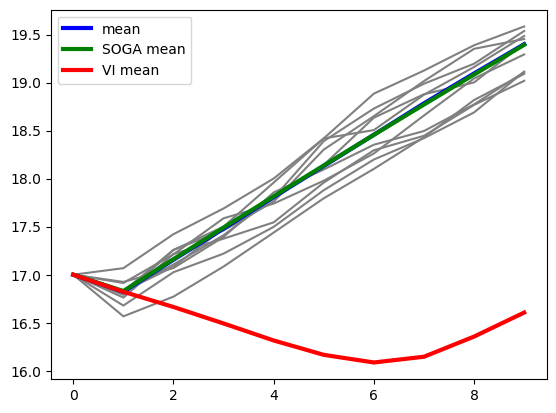

In [14]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='blue', label='mean')

#plt.plot(range(10), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(10), output_dist.gm.mean()[:10].detach(), lw=3, color='green', label='SOGA mean')

plt.plot(range(10), torch.mean(vi_traj_set, 0), lw=3, color='red', label='VI mean')

plt.legend()

### SOGA Bayesian

In [31]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/ThermostatBayesian.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

pars = {'tOffMean':22., 'tOnMean':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist_bayesian = start_SOGA(cfg, params_dict)

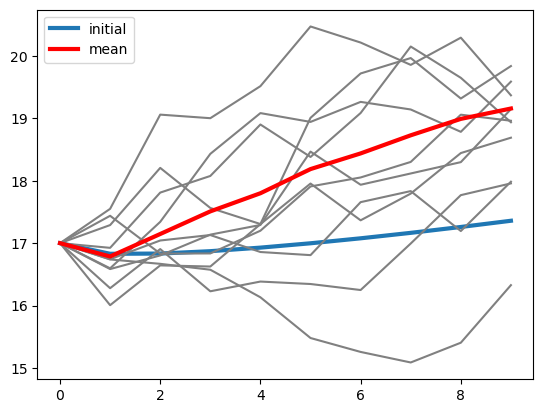

In [32]:
import matplotlib.pyplot as plt

y_init = output_dist_bayesian.gm.mean()[:10].detach()
plt.plot(range(10), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [33]:
def neg_log_likelihood(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx], idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist_bayesian)

tensor(751.6156, grad_fn=<NegBackward0>)

In [34]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)
pars = {'tOffMean':22., 'tOnMean':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimize(cfg, traj_set, params_dict, neg_log_likelihood, n_steps=100)


tOffMean: 21.95000000408218 tOnMean: 16.049999999986547  loss: 751.6156209827643
tOffMean: 21.876020543120248 tOnMean: 16.546076918690986  loss: 734.6105972950872
tOffMean: 21.824427359835614 tOnMean: 17.023408303571664  loss: 720.9786932848069
tOffMean: 21.769389507161044 tOnMean: 17.466869112422906  loss: 710.6505623271389
tOffMean: 21.716758927008797 tOnMean: 17.866067131822636  loss: 703.1836842967826
tOffMean: 21.670454732375756 tOnMean: 18.216658820393153  loss: 697.9590618380718
tOffMean: 21.631338199434634 tOnMean: 18.51946346630051  loss: 694.368347170056
tOffMean: 21.59904302982231 tOnMean: 18.778583198171813  loss: 691.9136146229619
tOffMean: 21.57279328368749 tOnMean: 18.999589261107616  loss: 690.2288284722355
tOffMean: 21.55144491594255 tOnMean: 19.188255755224954  loss: 689.0611377246175
Optimization performed in  526.846


In [35]:
params_dict

{'tOffMean': tensor(21.5351, requires_grad=True),
 'tOnMean': tensor(19.3348, requires_grad=True)}

In [36]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/ThermostatBayesian.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist_bayesian = start_SOGA(cfg, params_dict)

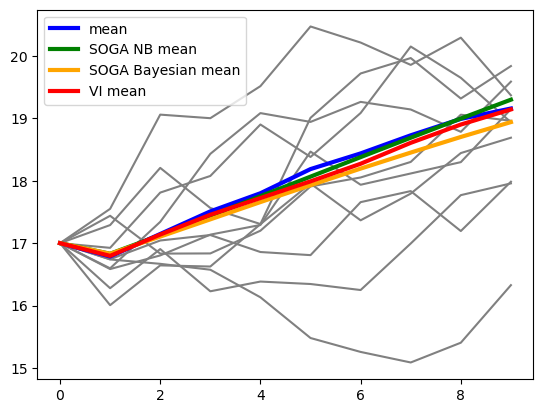

In [37]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='blue', label='mean')

#plt.plot(range(10), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(10), output_dist.gm.mean()[:10].detach(), lw=3, color='green', label='SOGA NB mean')

plt.plot(range(10), output_dist_bayesian.gm.mean()[:10].detach(), lw=3, color='orange', label='SOGA Bayesian mean')


plt.plot(range(10), torch.mean(vi_traj_set, 0), lw=3, color='red', label='VI mean')

plt.legend()